# 🧑‍💻 Mini Project Income – Instrucciones

## 🚀 Pasos para ejecutar este proyecto

1. **Clona el repositorio:**
   git clone https://github.com/XavrV/mini-project-income.git

2. **Mueve este notebook**
   Dentro de la carpeta clonada (`mini-project-income/`)
   *o* ábrelo directamente desde ahí si ya está incluido en el repo.

3. **Instala las dependencias antes de ejecutar el notebook:**

   * **Conda (recomendado):**

     conda env create -f environment.yml
     conda activate mini-project-income
   * **O con pip (si usas un env):**

     pip install -r requirements.txt

4. **El dataset `adult.csv` se descarga automáticamente al ejecutar la celda inicial del notebook.**

5. **¡Ya puedes correr el notebook!**
   Todos los módulos y funciones están en `src/` y se importan automáticamente.

**¿Dudas o problemas?**
Revisa el README, los comentarios del notebook, o abre un Issue en el repo.


### CLONA REPOSITORIO

In [ ]:
# Clonar el repo

!git clone https://github.com/XavrV/mini-project-income.git

# Mover este NoteBook a la carpeta del repo clonado


### IMPORTS Y SETUP

In [ ]:
# Descargar datos
!wget https://raw.githubusercontent.com/pooja2512/Adult-Census-Income/master/adult.csv -O data/adult.csv --quiet

In [1]:
# ---- Utilidades generales de sistema y pretty print ----
import sys
import os
import json
import pprint

# ---- Experiment tracking y modelado ----
import mlflow
import mlflow.sklearn
import joblib

# ---- Manipulación y análisis de datos ----
import numpy as np
import pandas as pd

# ---- Visualización ----
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Machine Learning y sklearn pipeline ----
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# ---- Jupyter/Notebook helpers (opcional, útil para display avanzado) ----
from IPython.display import display

# ---- Setup de path para importar tus módulos ----
sys.path.append("../")  # Para que Python encuentre todo en ../src

# ---- Imports de módulos propios del proyecto ----
from src.config import config
from src import (
    load_validate,
    target_processing,
    cleaning,
    eda,
    feature_engineering,
    split,
    pipeline,
    experiment
)

# ---- Warnings menos molestos en notebooks ----
import warnings
warnings.filterwarnings('ignore')

### CARGA Y VALIDACIÓN DEL DATASET

In [2]:
# Cargar dataset desde el path definido en el config
df = load_validate.load_dataset(config["path"])

# Valida columnas esperadas
df = load_validate.validate_structure(df, config["expected_columns"])

# Resumen estado inicial
summary = load_validate.quick_explore(df)

# Guarda estado inicial limpio para referencia
load_validate.save_initial_state(df, "data/initial_clean.csv")

# Muestra resumen
pprint.pprint(summary)


[INFO] Dataset cargado correctamente desde data/adult.csv con shape (32561, 15)
[INFO] Columnas finales en el DataFrame: ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
[INFO] Resumen rápido del dataset:
 - Shape: (32561, 15)
 - Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital.status': 0, 'occupation': 1843, 'relationship': 0, 'race': 0, 'sex': 0, 'capital.gain': 0, 'capital.loss': 0, 'hours.per.week': 0, 'native.country': 583, 'income': 0}
 - Únicos por columna: {'age': 73, 'workclass': 8, 'fnlwgt': 21648, 'education': 16, 'education.num': 16, 'marital.status': 7, 'occupation': 14, 'relationship': 6, 'race': 5, 'sex': 2, 'capital.gain': 119, 'capital.loss': 92, 'hours.per.week': 94, 'native.country': 41, 'income': 2}
[INFO] Estado inicial del dataset guardado en data/initial_c

### INSPECCIÓN, LIMPIEZA Y CODIFICACIÓN DEL TARGET

[INFO] Valores únicos y frecuencias en 'income': {'<=50K': 24720, '>50K': 7841}
[INFO] Frecuencias relativas: {'<=50K': 0.7591904425539756, '>50K': 0.2408095574460244}
[INFO] Nulos en target: 0
[INFO] Tipo de datos en target: object
[INFO] Target 'income' normalizado. Valores fuera de ['<=50K', '>50K']: 0
[INFO] Target codificado correctamente ({'<=50K': 0, '>50K': 1})
[INFO] Estado post-limpieza del target 'income':
  - Shape actual: (32561, 15)
  - Valores codificados: {np.int64(0): 24720, np.int64(1): 7841}
  - Filas eliminadas/cambiadas: 0


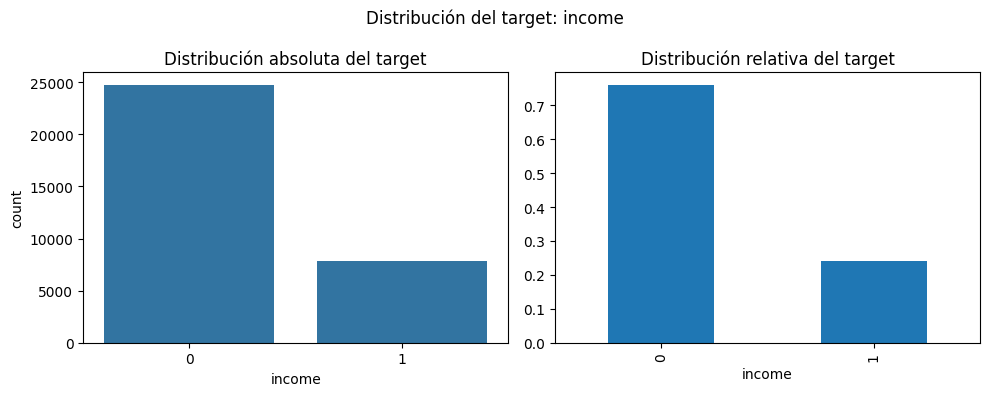

[INFO] Visualización de distribución de clases mostrada.
{'dtype': 'object',
 'n_missing': np.int64(0),
 'relative_frequencies': {'<=50K': 0.7591904425539756,
                          '>50K': 0.2408095574460244},
 'unique_values': {'<=50K': 24720, '>50K': 7841}}


In [3]:
# Inspecciona los valores del target (income) y detecta anomalías
target_summary = target_processing.inspect_target_values(df, config["target"])

# Limpia y normaliza los valores del target (espacios, mayúsculas, valores no válidos)
df = target_processing.clean_normalize_target(df, config["target"])

# Codifica el target para modelado usando el mapping definido en config
df = target_processing.encode_target(df, config["target"], config["target_mapping"])

# Logging del estado post-limpieza
removed_rows = df[config["target"]].isna().sum()
target_processing.log_target_status(df, config["target"], removed_rows)

# Visualiza la distribución de clases (balance de dataset)
target_processing.plot_target_distribution(df, config["target"])

# Si quieres, imprime el resumen para documentar
pprint.pprint(target_summary)


### LIMPIEZA BÁSICA DEL DATASET

In [4]:
# 1. Elimina duplicados completos
df, n_dupes = cleaning.drop_duplicates(df)

# 2. Analiza y reporta valores nulos (incluyendo target)
missing_summary = cleaning.analyze_missing_values(df, config["target"])

# 3. Corrige tipos y formatos evidentes (espacios, mayúsculas/minúsculas)
df = cleaning.fix_column_types_and_formats(df)

# 4. Revisión superficial de outliers groseros (sin modificar aún)
gross_outliers = cleaning.detect_gross_outliers(df, config["num_features"])

# 5. Logging de todo el estado post-limpieza básica
cleaning.log_cleaning_status(df, n_dupes, missing_summary)

# Opcional: imprime resumen de outliers para decisión posterior
pprint.pprint(gross_outliers)


[INFO] Duplicados eliminados: 24 (shape final: (32537, 15))
[INFO] Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital.status': 0, 'occupation': 1843, 'relationship': 0, 'race': 0, 'sex': 0, 'capital.gain': 0, 'capital.loss': 0, 'hours.per.week': 0, 'native.country': 582, 'income': 0}
[INFO] Total nulos en dataset: 4261
[INFO] Nulos en target: 0
[INFO] Tipos y formatos corregidos para columnas relevantes.
[INFO] Columna 'age': min=17, max=90, valores negativos=0
[INFO] Columna 'education.num': min=1, max=16, valores negativos=0
[INFO] Columna 'capital.gain': min=0, max=99999, valores negativos=0
[INFO] Columna 'capital.loss': min=0, max=4356, valores negativos=0
[INFO] Columna 'hours.per.week': min=1, max=99, valores negativos=0
[INFO] Estado tras limpieza básica:
  - Shape actual: (32537, 15)
  - Duplicados eliminados: 24
  - Nulos por columna: {'age': 0, 'workclass': 1836, 'fnlwgt': 0, 'education': 0, 'education.num': 0, 'marital

### Análisis Exploratorio

In [5]:
# Estadísticos descriptivos para numéricas
num_desc = eda.describe_numerical(df, config["num_features"])

# Estadísticos para categóricas (cardinalidad, más frecuente, top 5)
cat_desc = eda.describe_categorical(df, config["cat_features"])

[INFO] Estadísticos descriptivos (numéricas):
                  count         mean          std   min   25%   50%   75%  \
age             32537.0    38.585549    13.637984  17.0  28.0  37.0  48.0   
education.num   32537.0    10.081815     2.571633   1.0   9.0  10.0  12.0   
capital.gain    32537.0  1078.443741  7387.957424   0.0   0.0   0.0   0.0   
capital.loss    32537.0    87.368227   403.101833   0.0   0.0   0.0   0.0   
hours.per.week  32537.0    40.440329    12.346889   1.0  40.0  40.0  45.0   

                    max  
age                90.0  
education.num      16.0  
capital.gain    99999.0  
capital.loss     4356.0  
hours.per.week     99.0  
[INFO] Estadísticos descriptivos (categóricas):
              col  n_unique           most_freq  freq_most_freq  \
0       workclass         9             Private           22673   
1  marital.status         7  Married-civ-spouse           14970   
2      occupation        15      Prof-specialty            4136   
3    relationship  

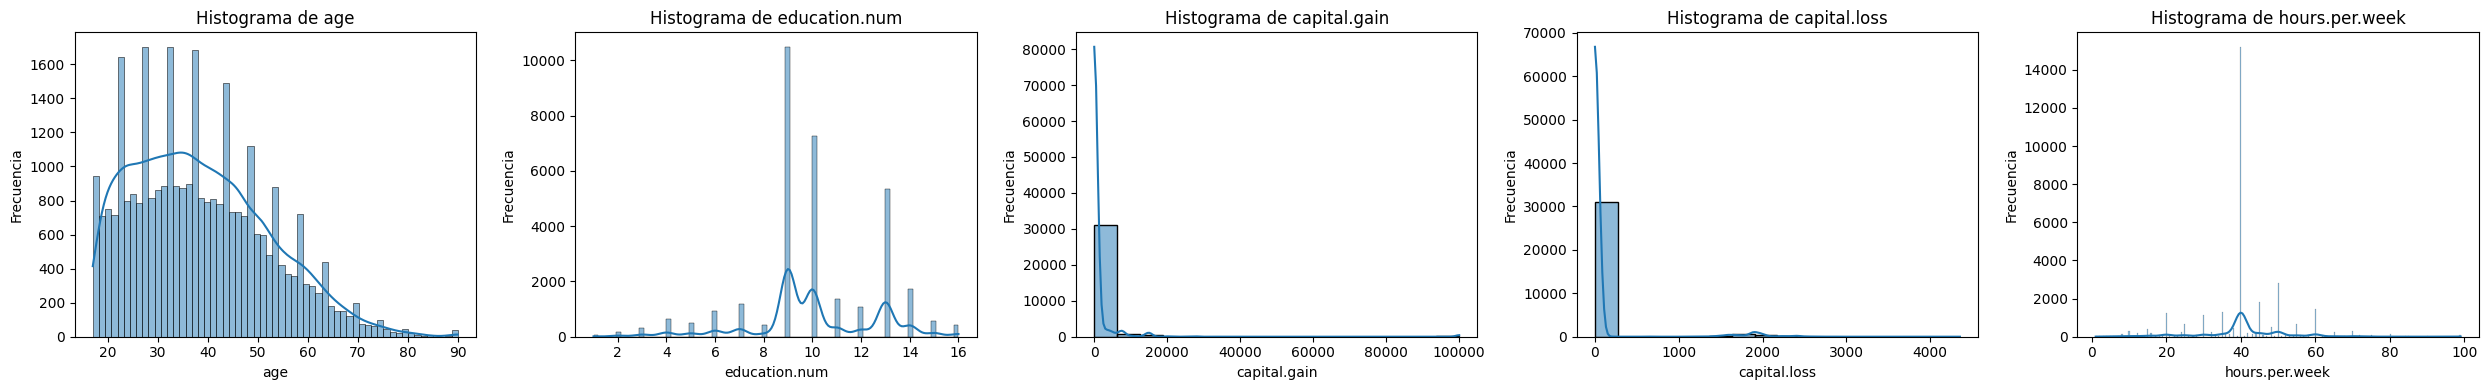

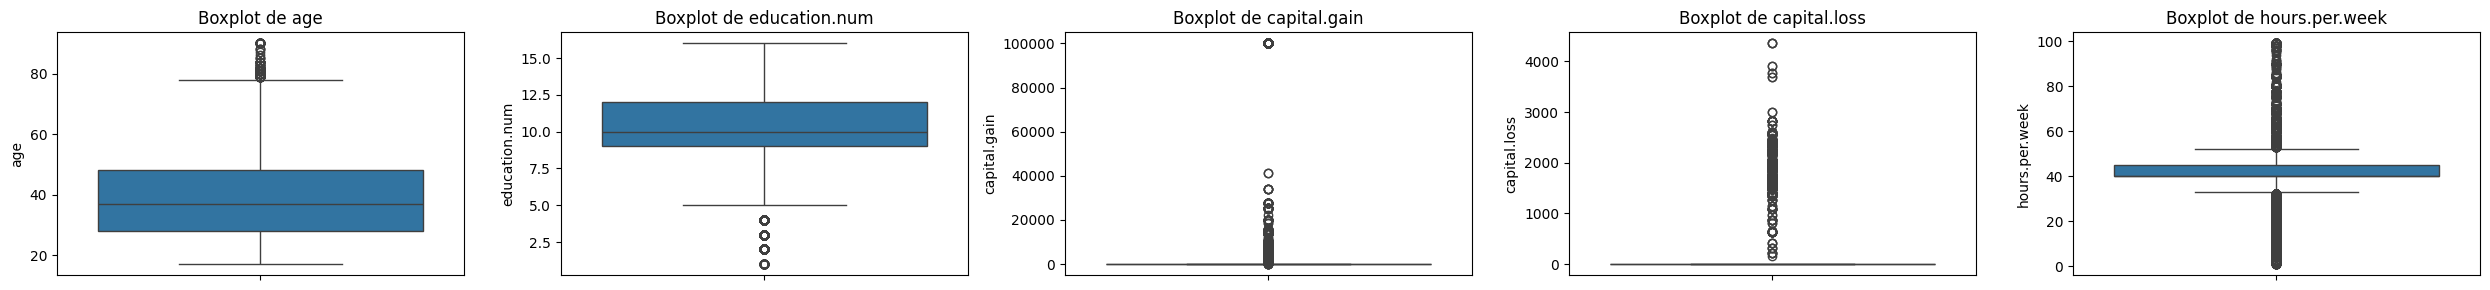

In [6]:
# Distribuciones de variables numéricas (histogramas + boxplots)
eda.plot_numerical_distributions(df, config["num_features"])

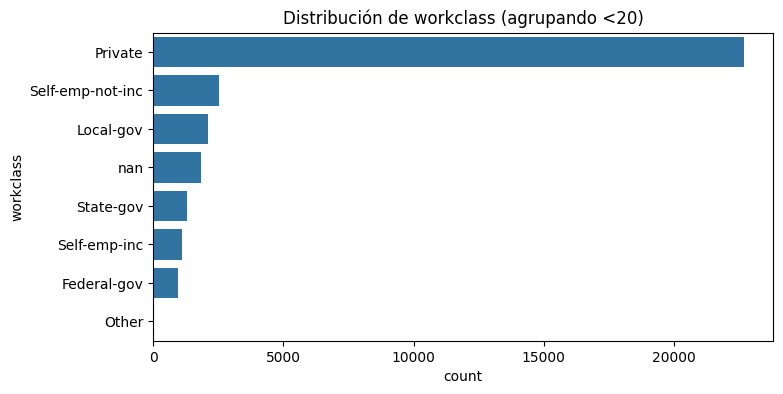

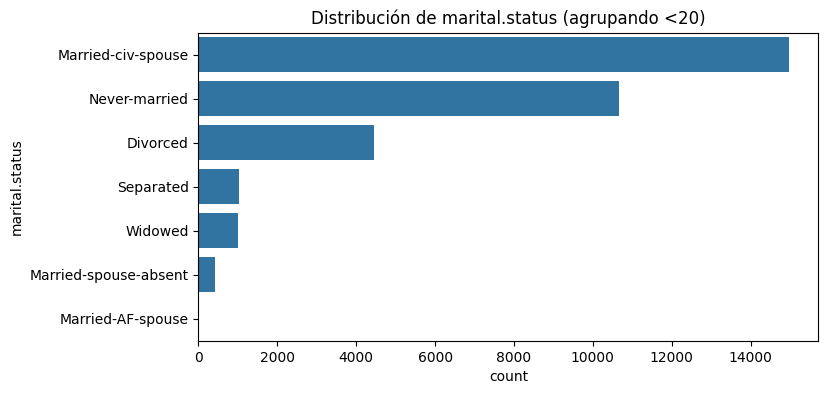

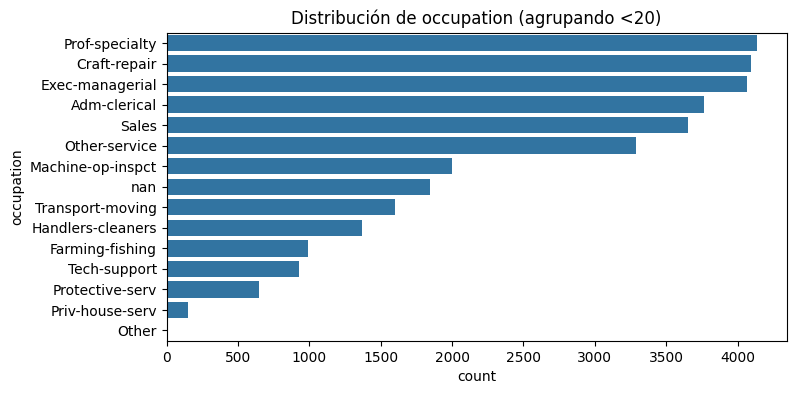

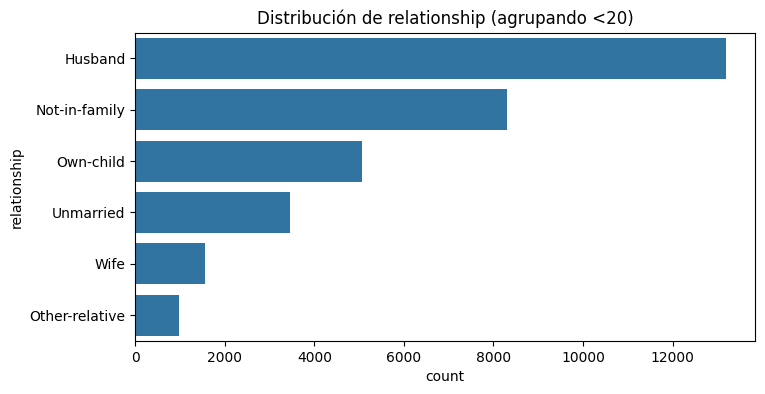

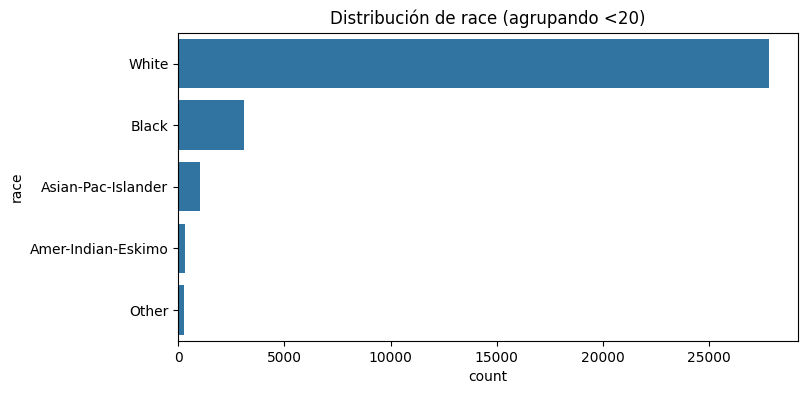

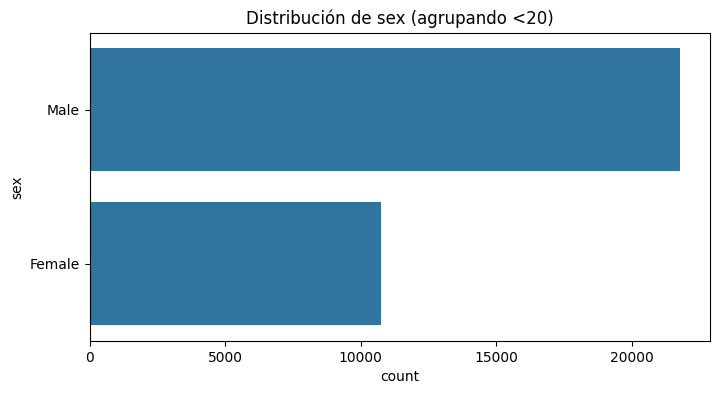

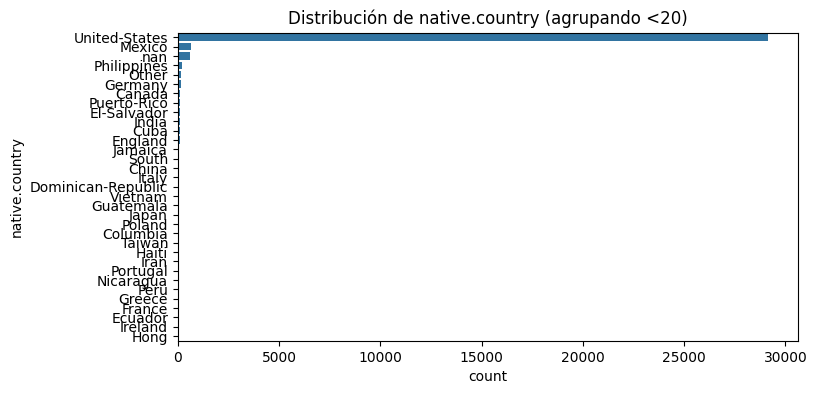

In [7]:
# Distribuciones de variables categóricas (conteo, agrupando bajas frecuencias)
eda.plot_categorical_distributions(df, config["cat_features"], min_freq=20)

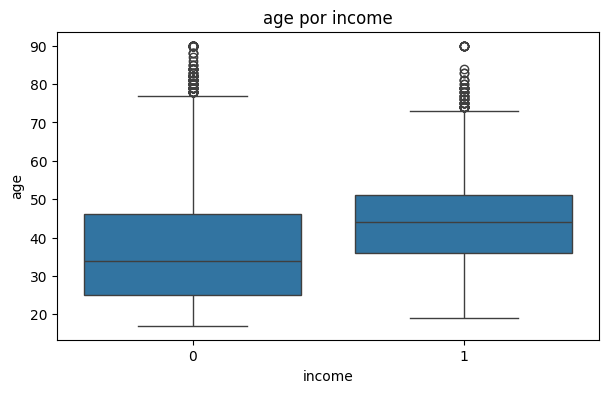

<Figure size 700x400 with 0 Axes>

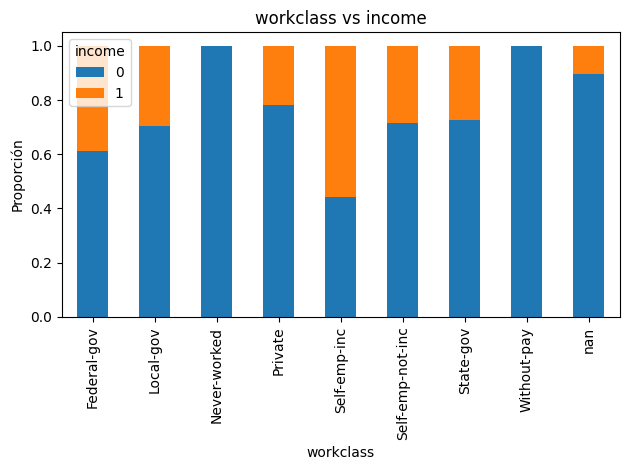

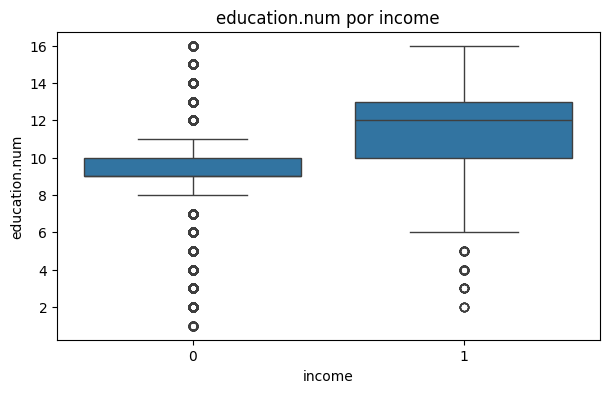

<Figure size 700x400 with 0 Axes>

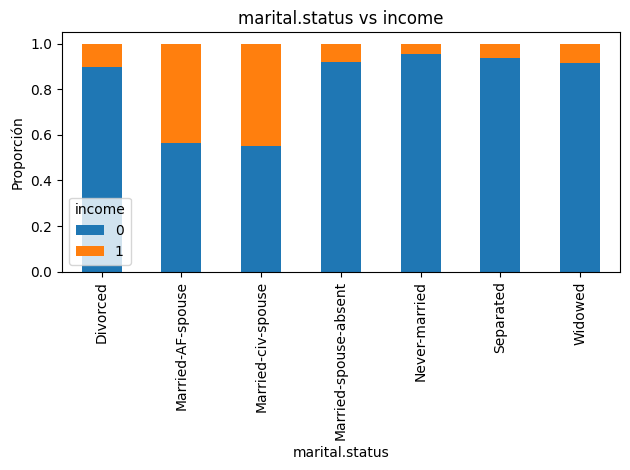

<Figure size 700x400 with 0 Axes>

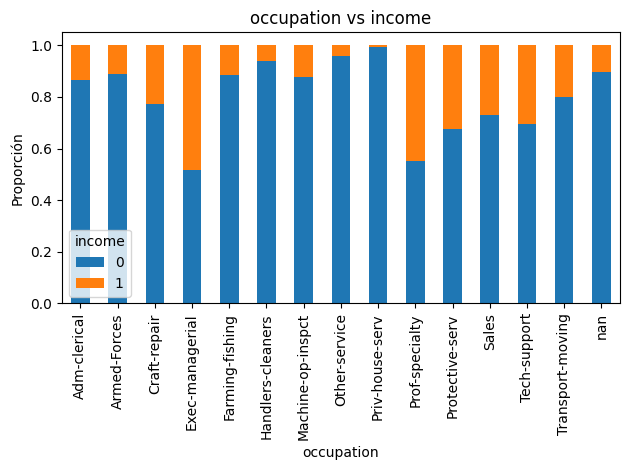

<Figure size 700x400 with 0 Axes>

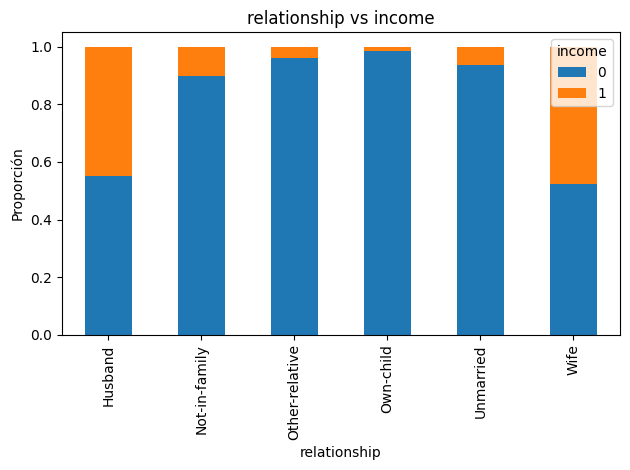

<Figure size 700x400 with 0 Axes>

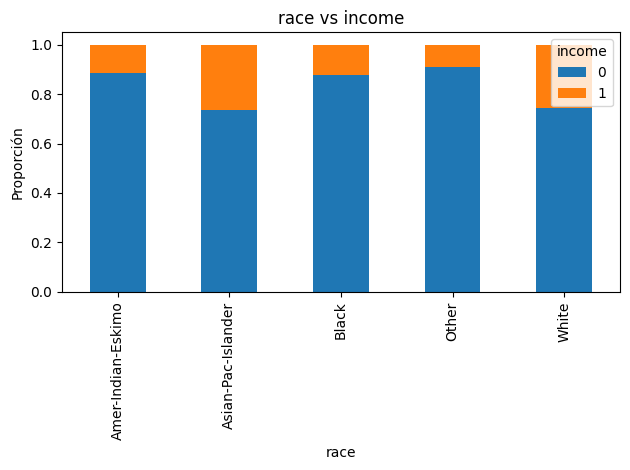

<Figure size 700x400 with 0 Axes>

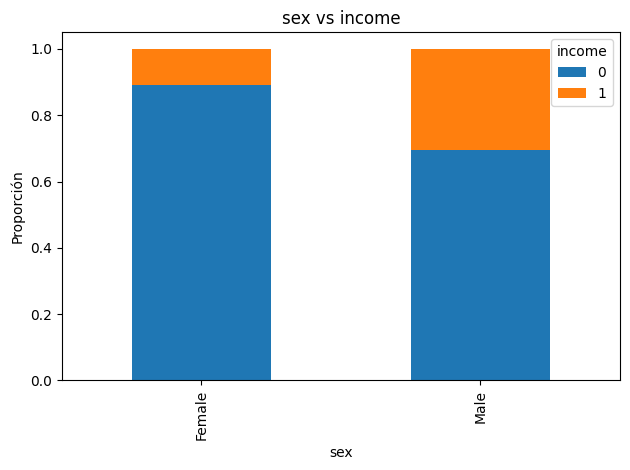

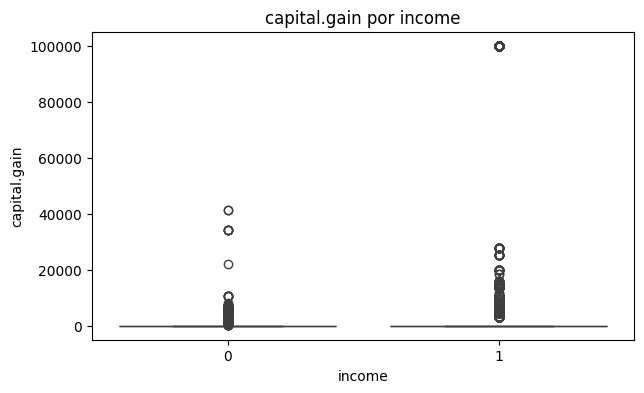

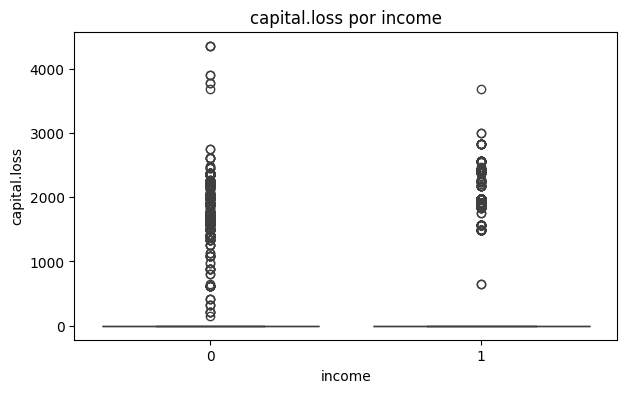

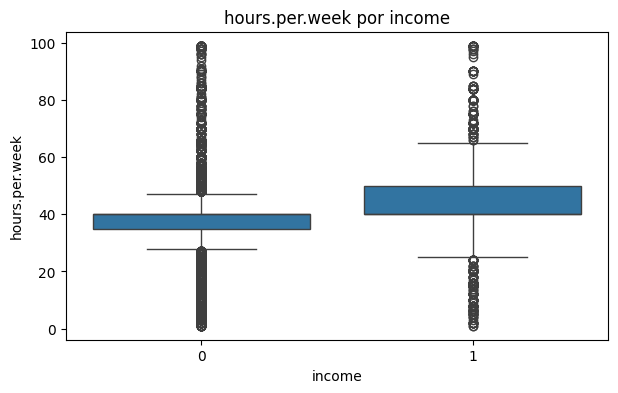

<Figure size 700x400 with 0 Axes>

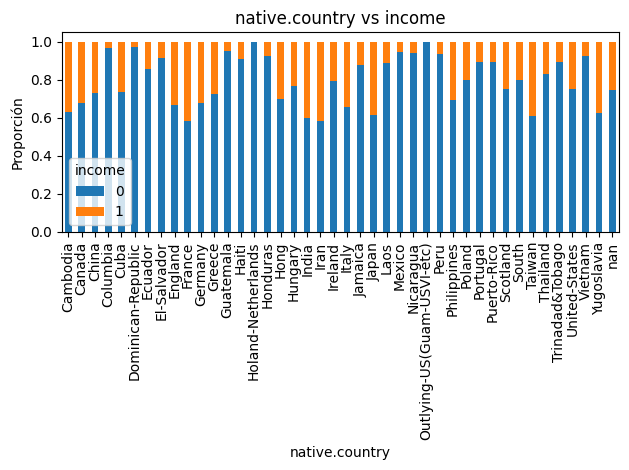

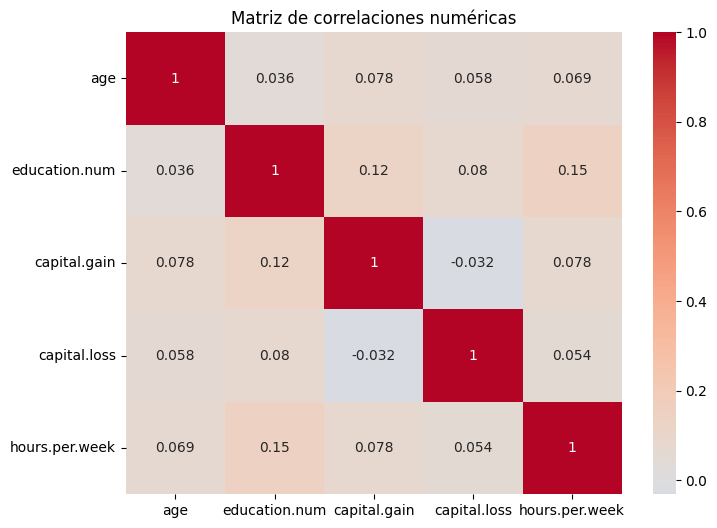

[INFO] Pares de features con |correlación| > 0.95: {}


In [8]:

# Relación univariada de cada feature con el target
eda.plot_feature_target_relationship(df, config["features"], config["target"])

# Correlación entre variables numéricas
corr_matrix = eda.correlation_analysis(df, config["num_features"])

# Detecta pares de features muy correlacionados (posibles redundancias)
redundant_pairs = eda.analyze_feature_redundancy(df, config["num_features"])

## Mini-Informe EDA

1. Variables Numéricas

Variables: age, education.num, capital.gain, capital.loss, hours.per.week

Distribución:

age: [17, 90], media ≈ 39, sesgada hacia adultos jóvenes, con outliers de 70+ años.

education.num: [1, 16], completa, mayoría entre 9-13 (HS-grad/college).

capital.gain/loss: Extremadamente sesgadas, la mayoría son 0, con spikes .

→ Winsorización o log-transform (?), puede perder significado.

hours.per.week: [1, 99], mayoría entre 35-45 (full-time), OL abajo de 10 y arriba de 70.

2. Variables Categóricas
Variables: workclass, marital.status, occupation, relationship, race, sex, native.country

Cardinalidad:

workclass: 8  (~1800 nulos)

occupation: 14  (~1800 nulos)

marital.status: 7 

relationship: 6 

race: 5 (mayoría "White")

sex: 2 ("Male" ≈ 2/3)

native.country: 41 (29/32 "United-States" -resto subrepresentado)

Observaciones:

Poco frecuentes en native.country, occupation y algunas en workclass.

Valores nulos concentrados en workclass, occupation, y native.country.

Agrupar raras en "Other" -evitar columnas dummies poco informativas.

3. Nulos
Total nulos: 4261 (excepto target)

workclass: 1836 nulos

occupation: 1843 nulos

native.country: 582 nulos

Categóricas:

Cardinalidades manejables, salvo native.country.

5. Relación con el Target

age: Los que ganan más de 50K tienden a ser mayores (desplazamiento hacia la derecha).

education.num: A más educación, más chances de >50K.

capital.gain/loss: Los que tienen capital gains/loss relevantes, desproporcionadamente ganan >50K (pocos casos).

hours.per.week: Ligeramente mayor para >50K, con solapamiento.

marital.status, occupation, relationship:

Ciertos valores (ej: "Exec-managerial", "Prof-specialty") fuertemente asociados a >50K.

"Married-civ-spouse" correlaciona fuerte con ingresos altos.

6. Insights inmediatos para Feature Engineering

Imputar nulos en categóricas usando "most_frequent" (moda).

En native.country, agrupar todas menos "United-States" como "Other".

Considerar transformar capital.gain y capital.loss (log, bins, winsorize).

Desbalance de clases: usar métrica  AUC/Recall.

Eliminar duplicidad entre education (string) y education.num si se comprueba que una no aporta extra.

### INGENIERÍA DE FEATURES -GROUPING

In [9]:
# 1. Análisis y documentación de redundancias e irrelevancias
redundancias = feature_engineering.analyze_feature_redundancy_irrelevance(
    df,
    features_info={
        "redundant": ["education"],  # 'education' por 'education.num'
        "irrelevant": ["fnlwgt"],    # no aporta
    }
)

# 2. Propone y documenta agrupamientos de categorías poco frecuentes
agrupamientos = feature_engineering.propose_category_groupings(
    df,
    config["cat_features"],
    min_freqs={k: v["min_freq"] for k, v in config["grouping"].items()},
    other_label="Other"
)

# 3. Define y documenta listas de features para modelar
features_dict = feature_engineering.prepare_final_features(
    df,
    config["drop_features"],    
    config["target"]          
)

# 4. Detecta issues pipeline (nulos, alta cardinalidad)
issues = feature_engineering.collect_pipeline_issues(df, features_dict)

# 5. Guarda config de features
feature_engineering.save_feature_config(features_dict, "features_config.json")

# 6. Muestra log
print("Redundancias e irrelevancias detectadas:")
pprint.pprint(redundancias)
print("\nAgrupamientos sugeridos:")
pprint.pprint(agrupamientos)
print("\nFeatures finales:")
pprint.pprint(features_dict)
print("\nIssues para pipeline:")
pprint.pprint(issues)


[INFO] Features redundantes: ['education']
[INFO] Features irrelevantes: ['fnlwgt']
[INFO] En 'workclass' se agruparán 8 categorías poco frecuentes como 'Other' (min_freq=3000).
[INFO] En 'marital.status' se agruparán 4 categorías poco frecuentes como 'Other' (min_freq=2000).
[INFO] En 'occupation' se agruparán 8 categorías poco frecuentes como 'Other' (min_freq=2000).
[INFO] En 'relationship' se agruparán 3 categorías poco frecuentes como 'Other' (min_freq=4000).
[INFO] En 'race' se agruparán 2 categorías poco frecuentes como 'Other' (min_freq=500).
[INFO] En 'native.country' se agruparán 41 categorías poco frecuentes como 'Other' (min_freq=1000).
[INFO] Features finales para modelado: {'final_features': ['age', 'workclass', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country'], 'final_num_features': ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week'], 'final_cat_featur

### SPLIT TRAIN/TEST y CONTROL DE CALIDAD

[INFO] Matriz X preparada (shape: (32537, 12)), vector y (shape: (32537,))
[INFO] Split estratificado hecho. X_train: (26029, 12), X_test: (6508, 12)
[INFO] Distribución de clases (train): {np.int64(0): 0.7590764147681432, np.int64(1): 0.24092358523185678}
[INFO] Distribución de clases (test): {np.int64(0): 0.7590657652120467, np.int64(1): 0.24093423478795328}
Distribución y calidad del split:
{'n_test': 6508,
 'n_test_null': np.int64(0),
 'n_train': 26029,
 'n_train_null': np.int64(0),
 'test_dist': {np.int64(0): 0.7590657652120467,
               np.int64(1): 0.24093423478795328},
 'train_dist': {np.int64(0): 0.7590764147681432,
                np.int64(1): 0.24092358523185678}}


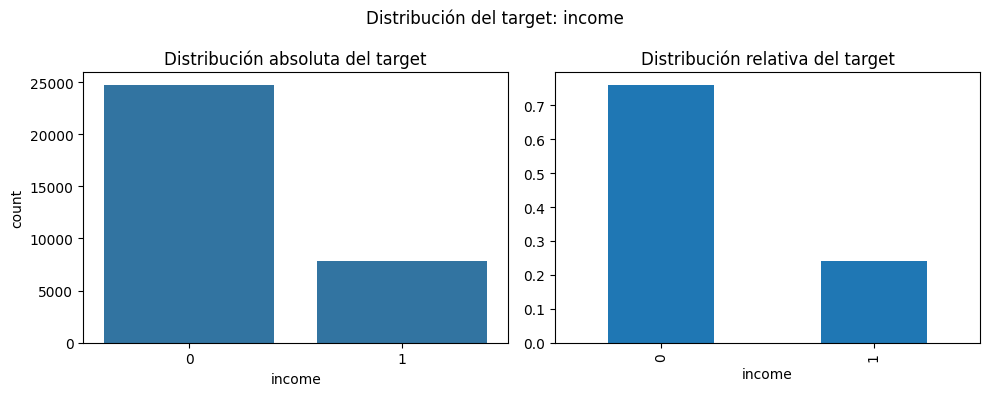

[INFO] Visualización de distribución de clases mostrada.


In [11]:
# 1. Carga features desde archivo (si no está ya cargado)
with open("features_config.json") as f:
    features_dict = json.load(f)

# 2. Prepara X (features) e y (target)
X, y = split.prepare_X_y(df, features_dict, config["target"])

# 3. Split estratificado
splits = split.stratified_train_test_split(
    X, y,
    test_size=config["split"]["test_size"],
    random_state=config["split"]["random_state"]
)

# 4. Chequea calidad del split
split_quality = split.check_split_quality(splits["y_train"], splits["y_test"])

# 5. Logging y guardado de los splits
# split.log_and_save_split_state(splits, out_dir="splits")

# 6. Mostrar resumen de calidad del split
print("Distribución y calidad del split:")
pprint.pprint(split_quality)

# 7. Plotea dist del target en train y test
target_processing.plot_target_distribution(df, config["target"])


## EXPERIMENTOS CON RANDOM FOREST

### PIPELINE

In [12]:
# Construye el pipeline completo (preprocesamiento + modelo) según config y features_dict (Descomentar modelo en config)
pipe = pipeline.build_pipeline(config, features_dict)

# Muestra el resumen del pipeline (estructura y pasos)
set_config(display="diagram")  # Activar visualización gráfica para Jupyter

pipe


[INFO] ColumnTransformer construido con 8 transformadores.
[INFO] Pipeline completo construido: RandomForestClassifier


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier',
                                                                   OutlierTransformer()),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'education.num',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('cat_workclass',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex']),
                                                 ('cat_native.country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   CategoryGrouper(col='native.country',
                                                                                   min_freq=1000)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['native.country'])])),
                ('model', RandomForestClassifier(random_state=42))])

### TEST: ENTRENAMIENTO RÁPIDO + TRACKING EN MLFLOW

In [ ]:
# 1. Setup de MLflow (tracking URI y nombre de experimento desde config)
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# 2. Entrenamiento con autolog y evaluación en test (sin gridsearch)
mlflow.sklearn.autolog()

with mlflow.start_run(run_name="entrenamiento_inicial"):
    # Fit del pipeline en los datos de entrenamiento
    pipe.fit(splits["X_train"], splits["y_train"])
    
    # Evaluación rápida en test
    score = pipe.score(splits["X_test"], splits["y_test"])
    print(f"[INFO] Score en test set: {score:.4f}")

    # Loguear la métrica test manualmente (opcional, por si quieres nombre custom)
    mlflow.log_metric("test_score", score)

    # (Opcional) Guardar el modelo entrenado como artefacto
    
    joblib.dump(pipe, "results_out/model_inicial.joblib")
    mlflow.log_artifact("results_out/model_inicial.joblib")


### GRID SEARCH EXPLORATORIO

In [ ]:
## Explorando imputadore y valores de corte para OL

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# Construye el pipeline como antes
pipe = pipeline.build_pipeline(config, features_dict)

# Define el param_grid para la búsqueda exploratoria
param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median", "mean"],

    # Imputación categórica en cada variable
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Outlier handling
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01, 0.02],   # percentiles bajos
    "preprocessing__num__outlier__pmax": [0.98, 0.99],   # percentiles altos

    # Hiperparámetros del RandomForest
    "model__n_estimators": [100, 300],
    "model__max_depth": [None, 10, 20],
}

# Corre el experimento con tracking y guardado de resultados
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="accuracy",
    cv=5,
    out_dir="results_out/prepro_imp_ol"
)

Mejores hiperparámetros: 

    max_depth: 10, 

    n_estimators: 300, 

    native.country__imputer__strategy: 'most_frequent', 

    occupation__imputer__strategy: 'most_frequent', 

    workclass__imputer__strategy: 'most_frequent', 

    num__imputer__strategy: 'median', 

    num__outlier__pmax: 0.98, 

    num__outlier__pmin: 0.01, 

    num__outlier__strategy: 'none'


##### VISUALIZACIÓN DE RESULTADOS

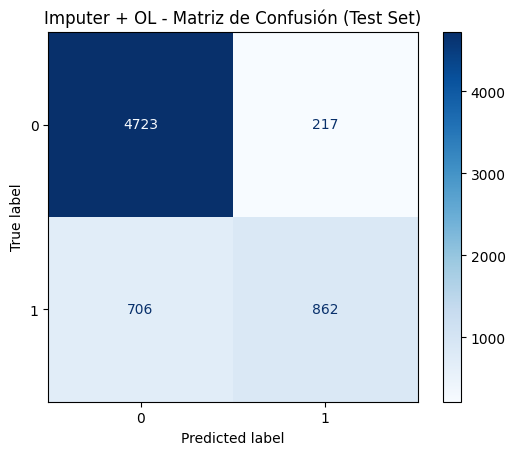

              precision    recall  f1-score   support

         0.0      0.870     0.956     0.911      4940
         1.0      0.799     0.550     0.651      1568

    accuracy                          0.858      6508
   macro avg      0.834     0.753     0.781      6508
weighted avg      0.853     0.858     0.848      6508



In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/prepro_imp_ol/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Imputer + OL - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))


#### GRID SEARCH USANDO BALANCE

In [ ]:
# Balancing Search -Agregamos class_weight y variantes de preprocesamiento

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)
param_grid = {
    "preprocessing__num__imputer__strategy": ["median"],
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],
    "preprocessing__num__outlier__pmax": [0.99],
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}, {0:1, 1:3}],
}
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/balancing_search"
)


Mejores hiperparámetros: {

    class_weight: None, 

    max_depth: 10, 

    n_estimators: 200, 

    num__imputer__strategy: 'median', 

    num__outlier__pmax: 0.99, 

    num__outlier__pmin: 0.01, 

    num__outlier__strategy: 'none'

    }


##### VISUALIZACIÓN DE RESULTADOS

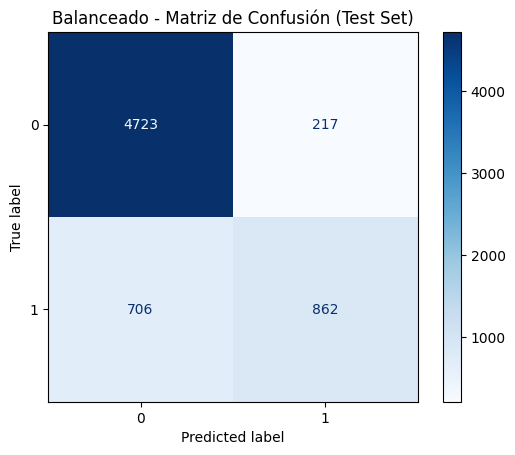

              precision    recall  f1-score   support

         0.0      0.870     0.956     0.911      4940
         1.0      0.799     0.550     0.651      1568

    accuracy                          0.858      6508
   macro avg      0.834     0.753     0.781      6508
weighted avg      0.853     0.858     0.848      6508



In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/balancing_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Balanceado - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## GRouping Search -Agregando agrupamiento de cat features a 'other'

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

# 1. Define un grid específico para min_freq en variables críticas
param_grid = {
    # Solo exploramos agrupamiento para evitar combinatoria excesiva
    "preprocessing__cat_native.country__grouper__min_freq": [1, 50, 200, 500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [1, 50, 200, 1000, 2000],
    "preprocessing__cat_workclass__grouper__min_freq": [1, 100, 1000, 3000],
    # Fijamos hiperparámetros conocidos
    "model__n_estimators": [300],
    "model__max_depth": [10],
    "model__class_weight": ["balanced"],
    # Outlier y demás fijos (ajusta si quieres testear también)
    "preprocessing__num__outlier__strategy": ["none"],
}


# 3. Construye el pipeline (usa features_dict según tu features_config.json)
pipe = pipeline.build_pipeline(config, features_dict)

# 4. Corre el experimento 
experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",    # O "f1"
    cv=5,
    out_dir="results_out/grouping_search"
)

[INFO] Mejores hiperparámetros: 

    class_weight: 'balanced',

    max_depth: 10, 

    n_estimators: 300, 

    native.country__grouper__min_freq: 500, 

    occupation__grouper__min_freq: 200, 

    workclass__grouper__min_freq: 3000, 

    num__outlier__strategy: 'none'


##### VISUALIZACIÓN DE RESULTADOS

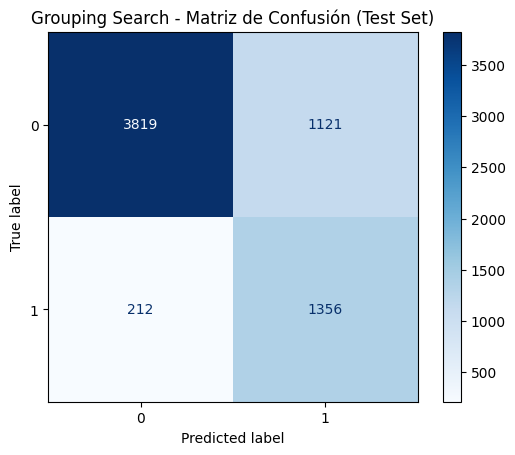

              precision    recall  f1-score   support

         0.0      0.947     0.773     0.851      4940
         1.0      0.547     0.865     0.670      1568

    accuracy                          0.795      6508
   macro avg      0.747     0.819     0.761      6508
weighted avg      0.851     0.795     0.808      6508



In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/grouping_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Grouping Search - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

#### COMBINANDO RESULTADOS ANTERIORES

In [ ]:
## Explorando combinaciones de best_params obtenidos

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median"],

    # Outlier handling (incluir "clip" para testear interacción)
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],  # solo usado si "clip"
    "preprocessing__num__outlier__pmax": [0.98, 0.99],  # solo usado si "clip"

    # Imputación categórica
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Agrupamiento de categorías poco frecuentes
    "preprocessing__cat_native.country__grouper__min_freq": [500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [200, 1000],
    "preprocessing__cat_workclass__grouper__min_freq": [1000, 3000],

    # RandomForest hiperparámetros
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}],
}

experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/comb_BestParams_search"
)


Mejores hiperparámetros: 

class_weight: None, 

max_depth: 20, 

n_estimators: 300, 

native.country__grouper__min_freq: 500, 

native.country__imputer__strategy: 'most_frequent',

occupation__grouper__min_freq: 200, 

occupation__imputer__strategy: 'most_frequent', 

workclass__grouper__min_freq: 1000, 

workclass__imputer__strategy: 'most_frequent', 

num__imputer__strategy: 'median',

num__outlier__pmax: 0.99, 

num__outlier__pmin: 0.01, 

num__outlier__strategy: 'clip'

##### VISUALIZACIÓN DE RESULTADOS

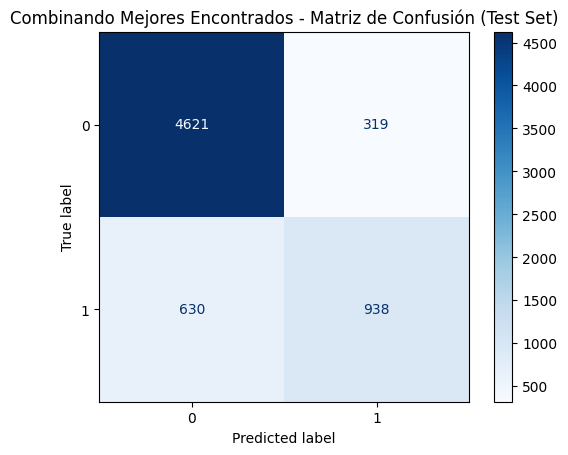

              precision    recall  f1-score   support

         0.0      0.880     0.935     0.907      4940
         1.0      0.746     0.598     0.664      1568

    accuracy                          0.854      6508
   macro avg      0.813     0.767     0.785      6508
weighted avg      0.848     0.854     0.848      6508



In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/comb_BestParams_search/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Combinando Mejores Encontrados - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

#### ÚLTIMOS (más) EXPERIMENTOS CON RF

In [ ]:
## Grid de Recapitulacion - Combinando lo aprendido

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    # Imputación numérica
    "preprocessing__num__imputer__strategy": ["median"],

    # Outlier handling (incluye clip para control)
    "preprocessing__num__outlier__strategy": ["none", "clip"],
    "preprocessing__num__outlier__pmin": [0.01],  # si clip
    "preprocessing__num__outlier__pmax": [0.99],  # si clip

    # Imputación categórica
    "preprocessing__cat_workclass__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_occupation__imputer__strategy": ["most_frequent"],
    "preprocessing__cat_native.country__imputer__strategy": ["most_frequent"],

    # Agrupamiento de categorías poco frecuentes (mejores de grids previos)
    "preprocessing__cat_native.country__grouper__min_freq": [500, 1000],
    "preprocessing__cat_occupation__grouper__min_freq": [200, 1000],
    "preprocessing__cat_workclass__grouper__min_freq": [1000, 3000],

    # RandomForest hiperparámetros
    "model__n_estimators": [200, 300],
    "model__max_depth": [10, 20],
    "model__class_weight": [None, "balanced", {0:1, 1:2}],
    # Si tienes implementado min_samples_leaf, puedes agregar: 
    "model__min_samples_leaf": [1, 5],
}


experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/mas_exps_rf" ## corregido nombre
)


Mejores hiperparámetros:
'model__class_weight': None, 

'model__max_depth': 20, 

'model__min_samples_leaf': 5, 

'model__n_estimators': 200, 

native.country__grouper__min_freq': 500, 

native.country__imputer__strategy': 'most_frequent', 

occupation__grouper__min_freq': 1000, 

occupation__imputer__strategy': 'most_frequent', 

workclass__grouper__min_freq': 1000, 

workclass__imputer__strategy': 'most_frequent', 

num__imputer__strategy': 'median', 

num__outlier__pmax': 0.99, 

num__outlier__pmin': 0.01, 

num__outlier__strategy': 'none'


##### VISUALIZACIÓN DE RESULTADOS

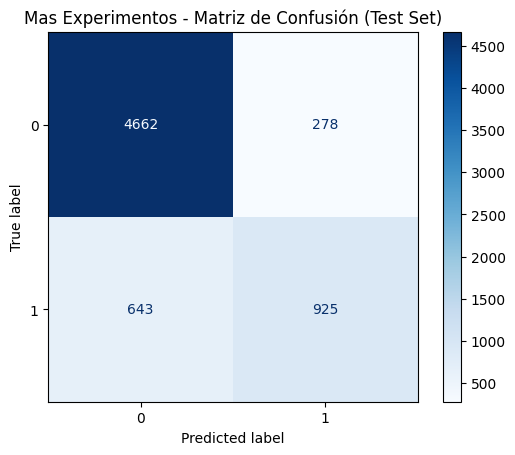

              precision    recall  f1-score   support

         0.0      0.879     0.944     0.910      4940
         1.0      0.769     0.590     0.668      1568

    accuracy                          0.858      6508
   macro avg      0.824     0.767     0.789      6508
weighted avg      0.852     0.858     0.852      6508



In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/mas_exps_rf/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Mas Experimentos - Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

### RESULTADOS CON RF

In [38]:
# Definir directorio donde están los resultados
base_dir = "results_out"
experiment_names = [
    "prepro_imp_ol",
    "balancing_search",
    "grouping_search",
    "comb_BestParams_search",
    "mas_exps_rf"
]

summary = []

for exp in experiment_names:
    exp_path = os.path.join(base_dir, exp)
    # Cargar mejores parámetros
    with open(os.path.join(exp_path, "best_params.json")) as f:
        best_params = json.load(f)
    # Cargar cv_results y tomar el mejor
    cv_results = pd.read_csv(os.path.join(exp_path, "cv_results.csv"))
    # Usualmente best_index_ está en los atributos, si no, tomamos el mejor según "mean_test_score"
    if "rank_test_score" in cv_results.columns:
        idx = cv_results["rank_test_score"].idxmin()
    else:
        idx = cv_results["mean_test_score"].idxmax()
    best_row = cv_results.iloc[idx]
    
    # Puedes agregar aquí las métricas que te interesen (f1, recall, etc)
    # O ajusta los nombres si cambiaste scoring
    summary.append({
        "experimento": exp,
        "accuracy (cv)": best_row.get("mean_test_score", None),
        "std (cv)": best_row.get("std_test_score", None),
        "params": best_params,
        # Si tienes más scorers, agrega aquí
        "mean_fit_time": best_row.get("mean_fit_time", None)
    })
    
# Crear dataframe resumen
summary_df = pd.DataFrame(summary)

# Mostrar tabla resumen ordenada por accuracy
display(summary_df.sort_values(by="accuracy (cv)", ascending=False))

,experimento,accuracy (cv),std (cv),params,mean_fit_time
4,mas_exps_rf,0.863460,0.003112,"{'model__class_weight': None, 'model__max_dept...",9.314338
3,comb_BestParams_search,0.862576,0.003698,"{'model__class_weight': None, 'model__max_dept...",14.611264
0,prepro_imp_ol,0.860310,0.002215,"{'model__class_weight': None, 'model__max_dept...",9.353398
1,balancing_search,0.860310,0.002215,"{'model__class_weight': None, 'model__max_dept...",8.232343
2,grouping_search,0.807945,0.002340,"{'model__class_weight': 'balanced', 'model__ma...",11.815081


/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)
/tmp/ipykernel_6938/2720286936.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_summary["experimento"], rotation=15)


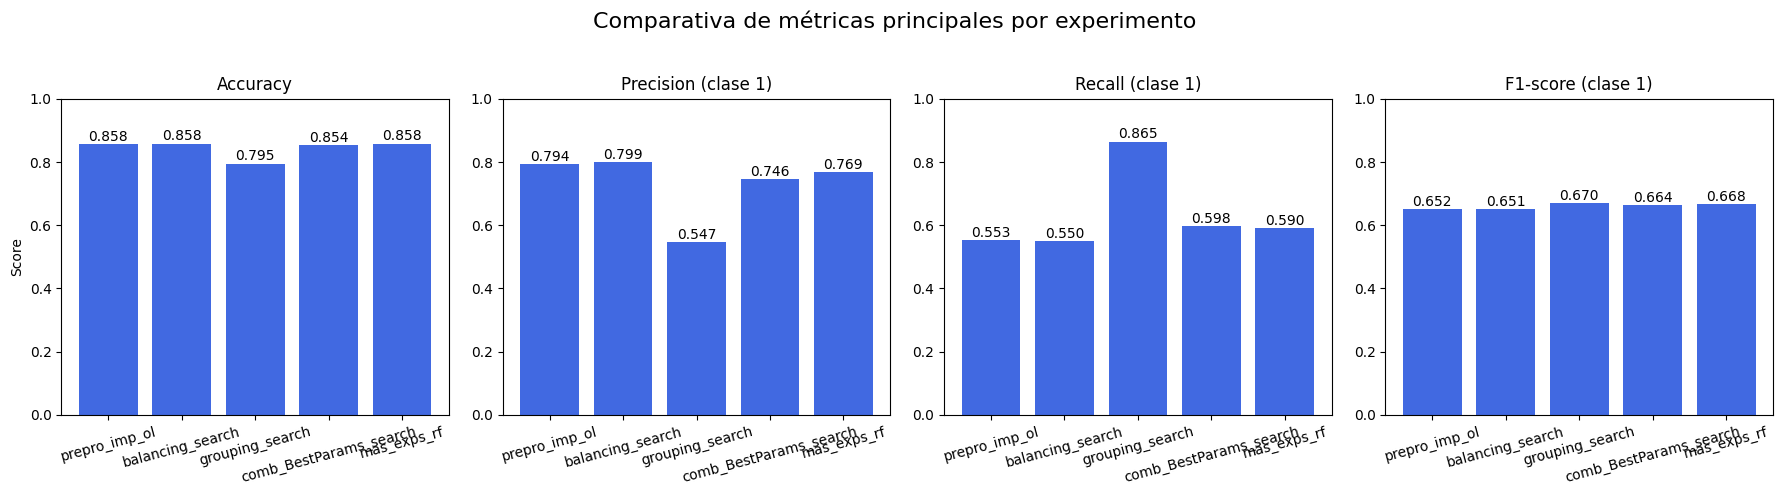

In [63]:
# Visualización comparativa de accuracy, recall, precision y f1-score
metrics = ["accuracy", "precision_1", "recall_1", "f1_1"]
titles = ["Accuracy", "Precision (clase 1)", "Recall (clase 1)", "F1-score (clase 1)"]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i]
    ax.bar(df_summary["experimento"], df_summary[metric], color="royalblue")
    ax.set_ylim(0, 1)
    ax.set_title(title)
    for idx, val in enumerate(df_summary[metric]):
        ax.text(idx, val + 0.01, f"{val:.3f}", ha="center")
    if i == 0:
        ax.set_ylabel("Score")
    ax.set_xticklabels(df_summary["experimento"], rotation=15)
plt.suptitle("Comparativa de métricas principales por experimento", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

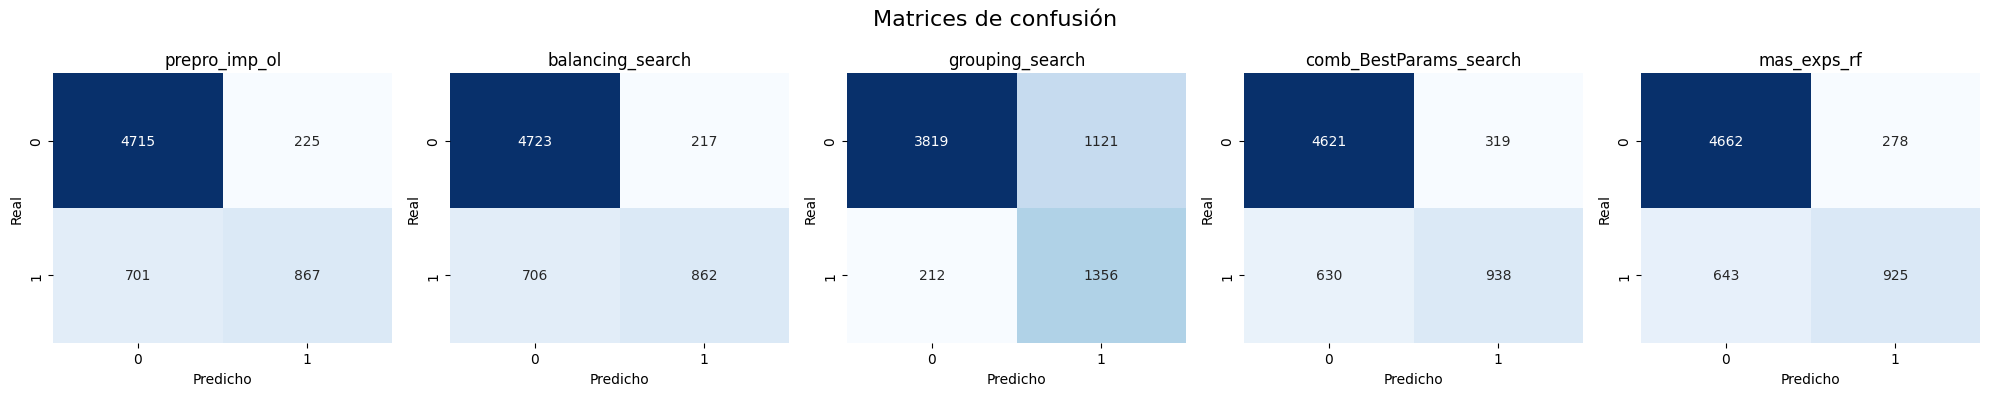

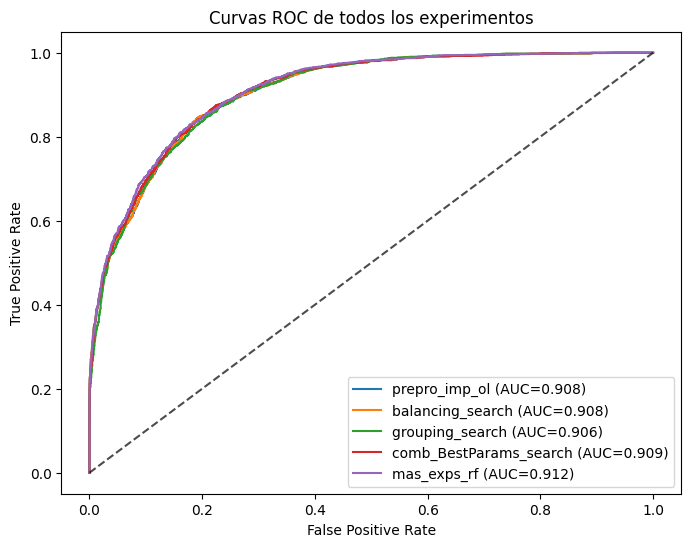

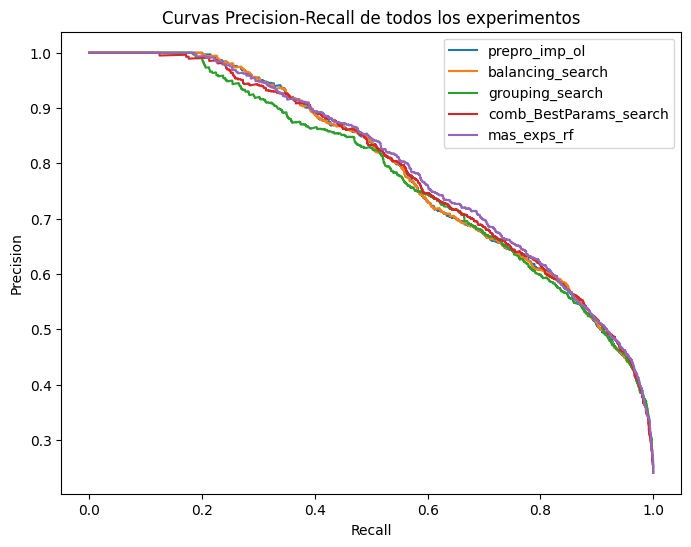

In [ ]:
# Para guardar resultados de cada experimento
results = {}

# Loop y almacenamos resultados de interés
for exp in experiment_names:
    exp_path = os.path.join(base_dir, exp)
    model = joblib.load(os.path.join(exp_path, "best_model.joblib"))
    with open(os.path.join(exp_path, "best_params.json")) as f:
        best_params = json.load(f)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[exp] = {
        "cm": cm,
        "roc": (fpr, tpr, roc_auc),
        "pr": (recall, precision),
        "report": report
    }

# Matrices de confusión (en panel)
n = len(experiment_names)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
for i, exp in enumerate(experiment_names):
    ax = axes[i]
    cm = results[exp]["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(exp)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
fig.suptitle("Matrices de confusión", fontsize=16)
plt.tight_layout()
plt.show()

# Curvas ROC (juntas)
plt.figure(figsize=(8,6))
for exp in experiment_names:
    fpr, tpr, roc_auc = results[exp]["roc"]
    plt.plot(fpr, tpr, label=f"{exp} (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC de todos los experimentos")
plt.legend()
plt.show()

# Curvas Precision-Recall (juntas)
plt.figure(figsize=(8,6))
for exp in experiment_names:
    recall, precision = results[exp]["pr"]
    plt.plot(recall, precision, label=exp)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curvas Precision-Recall de todos los experimentos")
plt.legend()
plt.show()

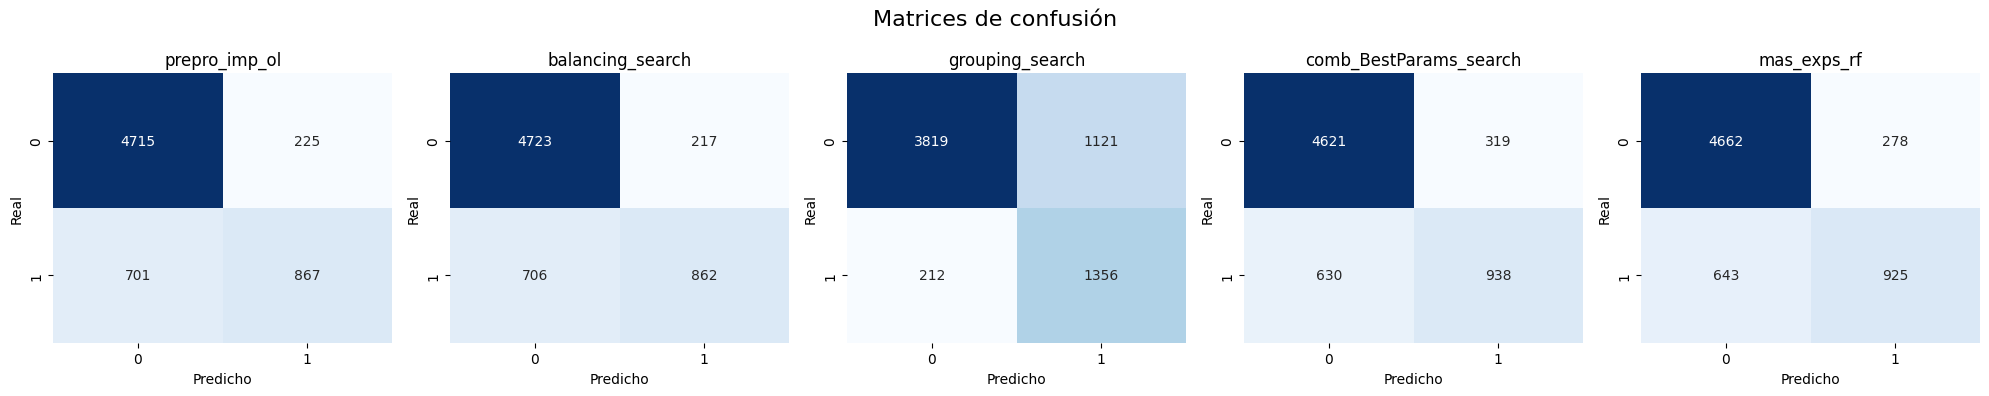
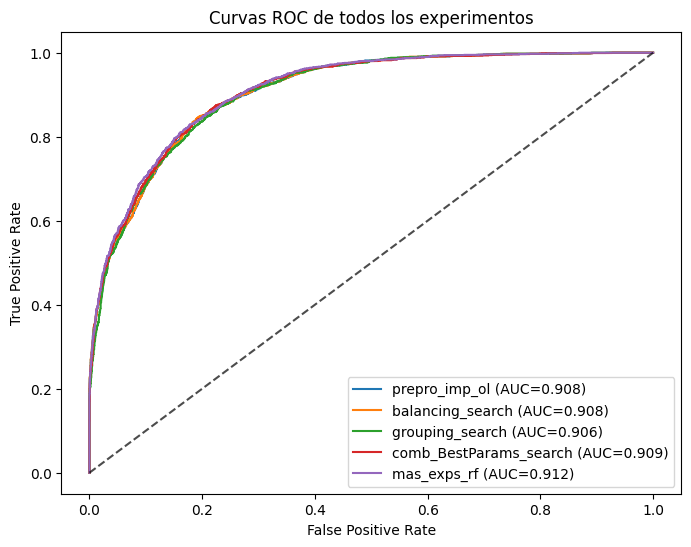
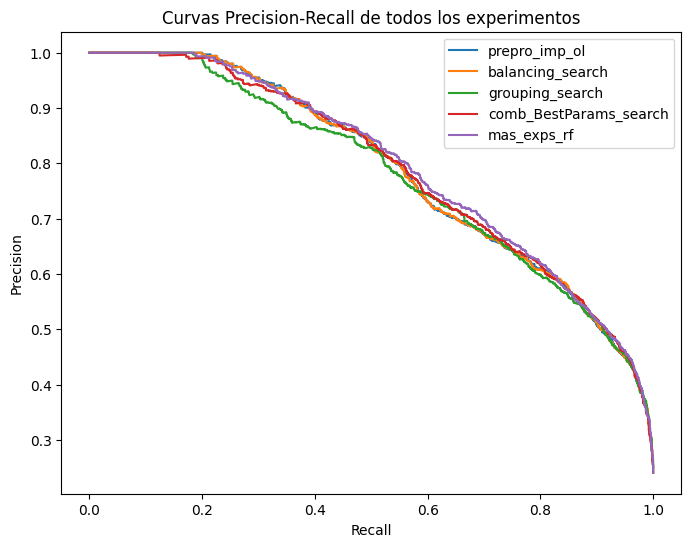

,accuracy,precision_1,recall_1,f1_1,roc_auc
experimento,,,,,
prepro_imp_ol,0.858,0.794,0.553,0.652,0.908
balancing_search,0.858,0.799,0.550,0.651,0.908
grouping_search,0.795,0.547,0.865,0.670,0.906
comb_BestParams_search,0.854,0.746,0.598,0.664,0.909
mas_exps_rf,0.858,0.769,0.590,0.668,0.912


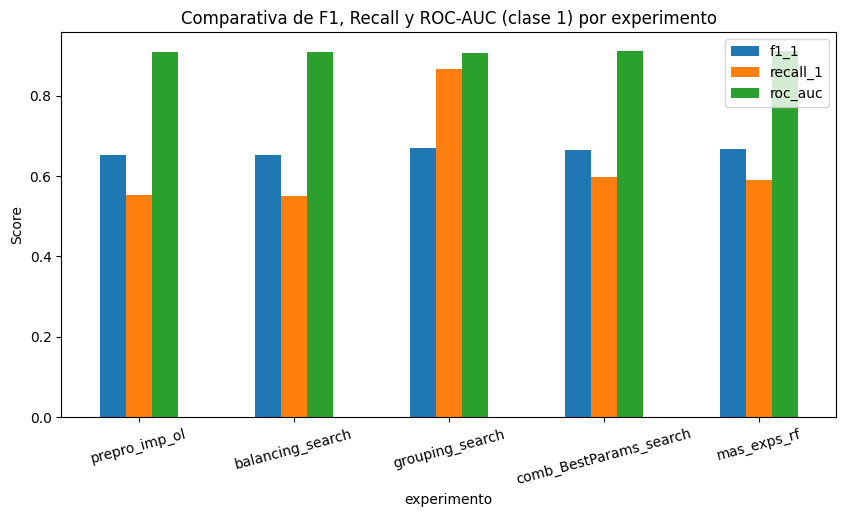

In [ ]:
# Tabla resumen de métricas principales

summary = []

for exp in experiment_names:
    r = results[exp]["report"]
    roc_auc = results[exp]["roc"][2]
    
    # Detectar la key que corresponde a la clase 1
    cls_keys = [k for k in r.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    pos_label = None
    for k in ['1', 1, 1.0, '>50K']:
        if k in cls_keys:
            pos_label = k
            break
    if pos_label is None:
        # Si no encuentra, elige el más alto (supone binario 0/1)
        try:
            pos_label = max(cls_keys, key=lambda x: float(x))
        except:
            pos_label = cls_keys[-1]  # fallback a último
    
    summary.append({
        "experimento": exp,
        "accuracy": r["accuracy"],
        "precision_1": r[pos_label]["precision"],
        "recall_1": r[pos_label]["recall"],
        "f1_1": r[pos_label]["f1-score"],
        "roc_auc": roc_auc
    })
df_summary = pd.DataFrame(summary)
display(df_summary.set_index("experimento").round(3))

# (Opcional: puedes graficar cada métrica comparativa con barras)
df_summary.set_index("experimento")[["f1_1", "recall_1", "roc_auc"]].plot.bar(figsize=(10,5), rot=15)
plt.title("Comparativa de F1, Recall y ROC-AUC (clase 1) por experimento")
plt.ylabel("Score")
plt.show()


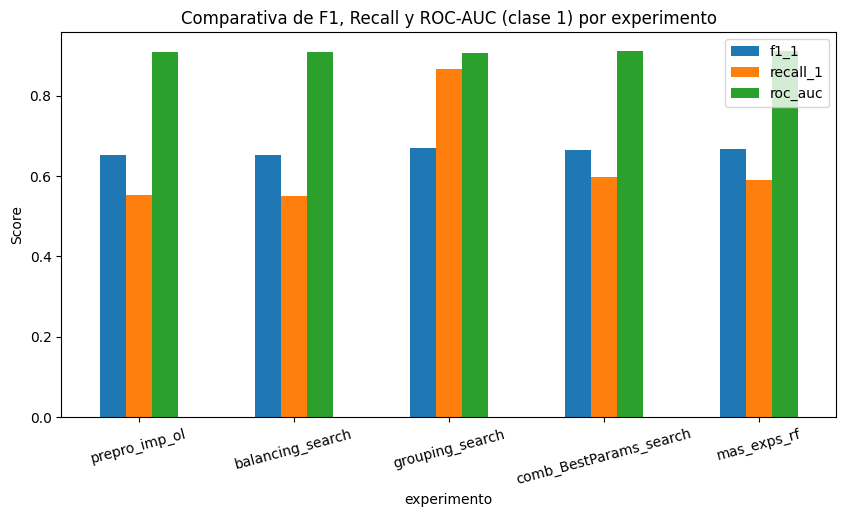

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>accuracy</th>
      <th>precision_1</th>
      <th>recall_1</th>
      <th>f1_1</th>
      <th>roc_auc</th>
    </tr>
    <tr>
      <th>experimento</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>prepro_imp_ol</th>
      <td>0.858</td>
      <td>0.794</td>
      <td>0.553</td>
      <td>0.652</td>
      <td>0.908</td>
    </tr>
    <tr>
      <th>balancing_search</th>
      <td>0.858</td>
      <td>0.799</td>
      <td>0.550</td>
      <td>0.651</td>
      <td>0.908</td>
    </tr>
    <tr>
      <th>grouping_search</th>
      <td>0.795</td>
      <td>0.547</td>
      <td>0.865</td>
      <td>0.670</td>
      <td>0.906</td>
    </tr>
    <tr>
      <th>comb_BestParams_search</th>
      <td>0.854</td>
      <td>0.746</td>
      <td>0.598</td>
      <td>0.664</td>
      <td>0.909</td>
    </tr>
    <tr>
      <th>mas_exps_rf</th>
      <td>0.858</td>
      <td>0.769</td>
      <td>0.590</td>
      <td>0.668</td>
      <td>0.912</td>
    </tr>
  </tbody>
</table>
</div>

## EXPERIMENTOS CON LOGISTIC REGRESSION

In [6]:
x_train, x_test, y_train, y_test = splits["X_train"], splits["X_test"], splits["y_train"], splits["y_test"]

In [6]:
from src.pipeline import build_pipeline

# 1. Construye el pipeline completo (prepro + modelo)
pipe = build_pipeline(config, features_dict)


[INFO] ColumnTransformer construido con 8 transformadores.
[INFO] Pipeline completo construido: LogisticRegression


In [ ]:
##GRID INICIAL USANDO LOG REGRESSION  (Descomentar modelo en config.py!)
# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    "preprocessing__num__scaler": [StandardScaler(), MinMaxScaler(), RobustScaler()],
    
    "preprocessing__num__outlier__strategy": ["clip", "none"],
    "preprocessing__num__outlier__pmin": [0.01, 0.05],
    "preprocessing__num__outlier__pmax": [0.99, 0.95],
    
    "preprocessing__num__imputer__strategy": ["median", "mean"],
    
    "preprocessing__cat_workclass__grouper__min_freq": [3000],
    "preprocessing__cat_marital.status__grouper__min_freq": [2000],
    "preprocessing__cat_occupation__grouper__min_freq": [2000],
    "preprocessing__cat_relationship__grouper__min_freq": [4000],
    "preprocessing__cat_race__grouper__min_freq": [1000],
    "preprocessing__cat_native.country__grouper__min_freq": [1000],
    
    "model__C": [0.1, 1, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}



experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/log_regression" ## corregido nombre
)


Mejor score (cv): 0.8487840565253351

Mejores hiperparámetros:

C': 0.1

penalty: 'l2'

solver: 'lbfgs'


marital.status grouper min_freq: 2000

occupation grouper min_freq: 2000

race grouper min_freq: 1000

relationship grouper min_freq: 4000

workclass grouper min_freq: 3000


num imputer strategy: 'median'

num outlier pmax: 0.99

num outlier pmin: 0.05

num outlier strategy: 'clip'

num scaler: MinMaxScaler()

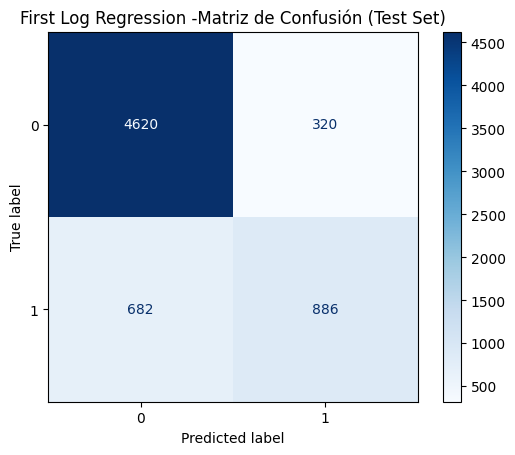

              precision    recall  f1-score   support

         0.0      0.871     0.935     0.902      4940
         1.0      0.735     0.565     0.639      1568

    accuracy                          0.846      6508
   macro avg      0.803     0.750     0.770      6508
weighted avg      0.838     0.846     0.839      6508



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/log_regression/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("First Log Regression -Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## SEGUNDO GRID USANDO LOG REGRESSION 

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)

param_grid = {
    "preprocessing__num__scaler": [MinMaxScaler()],
    "preprocessing__num__outlier__strategy": ["clip"],
    "preprocessing__num__outlier__pmin": [0.05],
    "preprocessing__num__outlier__pmax": [0.99],
    "preprocessing__num__imputer__strategy": ["median"],
    "preprocessing__cat_workclass__grouper__min_freq": [2500, 3000, 3500],
    "preprocessing__cat_occupation__grouper__min_freq": [1500, 2000, 2500],
    "preprocessing__cat_native.country__grouper__min_freq": [900, 1000, 1200],
    "model__C": [0.01, 0.05, 0.1, 0.2],
    "model__penalty": ["l2", "l1"],                 # l1/liblinear para ver sparsity
}


experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/log_regression_tuned" ## CAMBIAR NOMBRE!!
)


Mejor score (cv): 0.8487840491445067

Mejores hiperparámetros:

C: 0.1

penalty: 'l2'

native.country grouper min_freq: 900

occupation grouper min_freq: 1500

workclass grouper min_freq: 2500


num imputer strategy: 'median'

num outlier pmax: 0.99

num outlier pmin': 0.05

num outlier strategy': 'clip'

num scaler: MinMaxScaler()

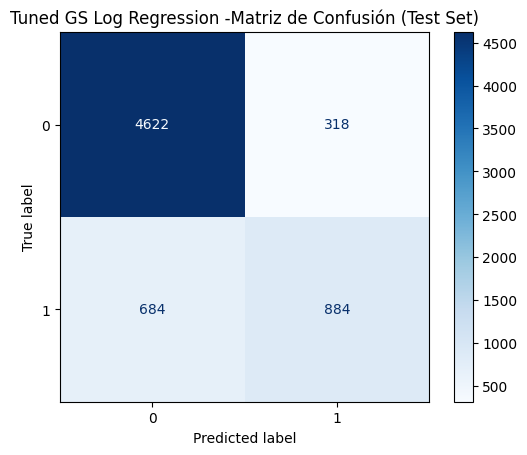

              precision    recall  f1-score   support

         0.0      0.871     0.936     0.902      4940
         1.0      0.735     0.564     0.638      1568

    accuracy                          0.846      6508
   macro avg      0.803     0.750     0.770      6508
weighted avg      0.838     0.846     0.839      6508



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/log_regression_tuned/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Tuned GS Log Regression -Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## TERCER GRID USANDO LOG REGRESSION 

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)


param_grid = {
    # Regularización aún más fuerte (¡podrías incluir hasta 0.001!)
    "model__C": [0.001, 0.01, 0.05, 0.1],

    # Agrupamiento: prueba alrededor del óptimo
    "preprocessing__cat_workclass__grouper__min_freq": [2000, 2500, 3000],
    "preprocessing__cat_occupation__grouper__min_freq": [1000, 1500, 2000],
    "preprocessing__cat_native.country__grouper__min_freq": [700, 900, 1100],

    # Mantén lo demás fijo
    "preprocessing__num__scaler": [MinMaxScaler()],
    "preprocessing__num__outlier__strategy": ["clip"],
    "preprocessing__num__outlier__pmin": [0.05],
    "preprocessing__num__outlier__pmax": [0.99],
    "preprocessing__num__imputer__strategy": ["median"],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"],
}


experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/log_regression_tuned1" ## CAMBIAR NOMBRE!!
)


Mejor score (cv): 0.8490530065250212

Mejores hiperparámetros:

C: 0.1

penalty: 'l2'

solver: 'lbfgs'

native.country__grouper__min_freq: 700

occupation grouper min_freq: 1000

workclass grouper min_freq: 2000

num imputer strategy: 'median'

num outlier pmax: 0.99

num outlier pmin: 0.05

num outlier strategy: 'clip'

num scaler: MinMaxScaler()


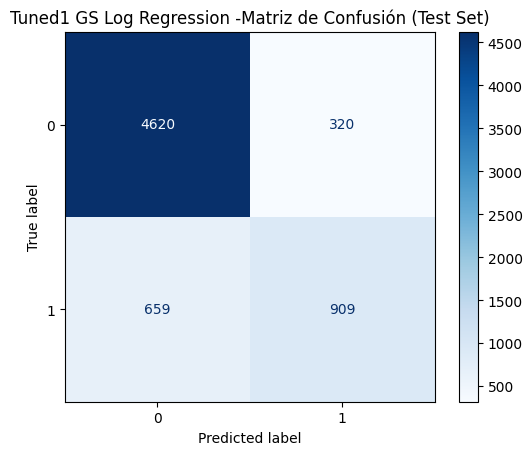

              precision    recall  f1-score   support

         0.0      0.875     0.935     0.904      4940
         1.0      0.740     0.580     0.650      1568

    accuracy                          0.850      6508
   macro avg      0.807     0.757     0.777      6508
weighted avg      0.843     0.850     0.843      6508



In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/log_regression_tuned1/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Tuned1 GS Log Regression -Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## TERCER GRID USANDO LOG REGRESSION ( Agresivo l1)

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)


param_grid = {
    # L1 penalty
    "model__penalty": ["l1"],
    "model__solver": ["liblinear"],
    "model__C": [0.001, 0.01, 0.05, 0.1, 0.15],

    # Recorte fuerte de outliers
    "preprocessing__num__outlier__strategy": ["clip"],
    "preprocessing__num__outlier__pmin": [0.05, 0.10, 0.20],
    "preprocessing__num__outlier__pmax": [0.95, 0.90, 0.80],

    # Agrupamiento: min_freq ALTO, para ver efecto
    "preprocessing__cat_workclass__grouper__min_freq": [4000, 5000],
    "preprocessing__cat_occupation__grouper__min_freq": [3000, 4000],
    "preprocessing__cat_native.country__grouper__min_freq": [1000, 3000],

    # Lo demás fijo
    "preprocessing__num__scaler": [MinMaxScaler()],
    "preprocessing__num__imputer__strategy": ["median"],
}



experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/log_regression_l1" ## CAMBIAR NOMBRE!!
)


Mejor score (cv): 0.8365284126827724

Mejores hiperparámetros:

C': 0.05

penalty': 'l1'

solver': 'liblinear'

native.country__grouper__min_freq': 3000

occupation__grouper__min_freq': 3000

workclass__grouper__min_freq': 4000

num__imputer__strategy': 'median'

num__outlier__pmax': 0.95

num__outlier__pmin': 0.1

num__outlier__strategy': 'clip'

num__scaler': MinMaxScaler()

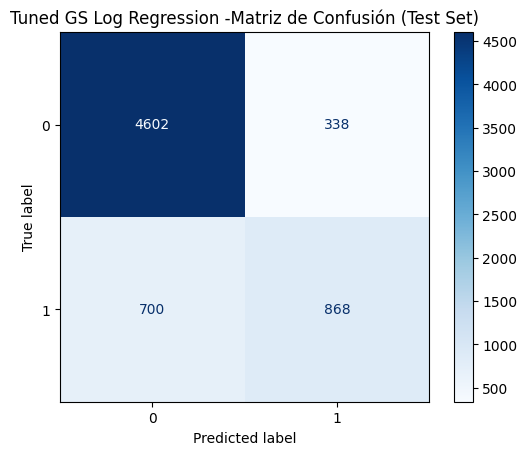

              precision    recall  f1-score   support

         0.0      0.868     0.932     0.899      4940
         1.0      0.720     0.554     0.626      1568

    accuracy                          0.841      6508
   macro avg      0.794     0.743     0.762      6508
weighted avg      0.832     0.841     0.833      6508



In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/log_regression_l1/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Tuned GS Log Regression -Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [ ]:
## CUARTO GRID USANDO LOG REGRESSION (antes de threshold tuning)

# MLflow
experiment.setup_mlflow_experiment(
    config["mlflow"]["tracking_uri"], 
    config["mlflow"]["experiment_name"]
)


param_grid = {
    # Solo para afinar regularización -puede sumar-
    "model__C": [0.05, 0.1, 0.15],
    "model__penalty": ["l2"],  
    "model__solver": ["lbfgs"],

    # Preprocesamiento FIRMADO en lo óptimo:
    "preprocessing__num__scaler": [MinMaxScaler()],
    "preprocessing__num__outlier__strategy": ["clip"],
    "preprocessing__num__outlier__pmin": [0.05],
    "preprocessing__num__outlier__pmax": [0.99],
    "preprocessing__num__imputer__strategy": ["median"],

    "preprocessing__cat_workclass__grouper__min_freq": [2000],
    "preprocessing__cat_occupation__grouper__min_freq": [1000],
    "preprocessing__cat_native.country__grouper__min_freq": [700],
}


experiment.run_gridsearch_experiment(
    pipeline=pipe,
    param_grid=param_grid,
    X_train=splits["X_train"],
    y_train=splits["y_train"],
    X_test=splits["X_test"],
    y_test=splits["y_test"],
    scoring="recall",  # o "f1"
    cv=5,
    out_dir="results_out/log_regression_threshold" ## CAMBIAR NOMBRE!!
)

Mejor score (cv): 0.8490530065250212

Mejores hiperparámetros:

C: 0.1

penalty: 'l2'

solver: 'lbfgs'

native.country grouper min_freq: 700

occupation grouper min_freq: 1000

workclass grouper min_freq: 2000

num imputer strategy: 'median'

num outlier pmax: 0.99

num outlier pmin: 0.05

num outlier strategy: 'clip'

num scaler: MinMaxScaler()

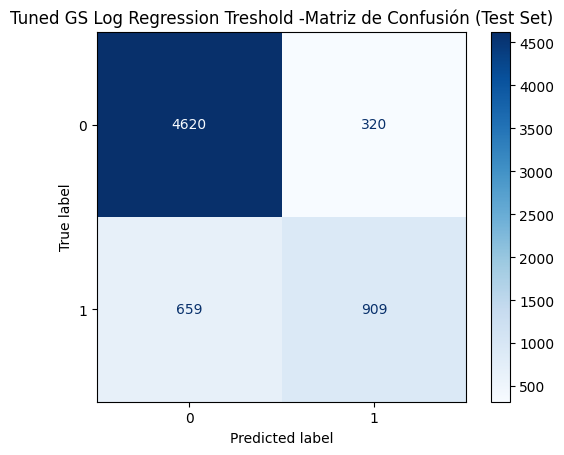

              precision    recall  f1-score   support

         0.0      0.875     0.935     0.904      4940
         1.0      0.740     0.580     0.650      1568

    accuracy                          0.850      6508
   macro avg      0.807     0.757     0.777      6508
weighted avg      0.843     0.850     0.843      6508



In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# El mejor modelo entrenado
best_model = joblib.load("results_out/log_regression_threshold/best_model.joblib")
y_pred = best_model.predict(splits["X_test"])

# Matriz de confusión
cm = confusion_matrix(splits["y_test"], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Tuned GS Log Regression Treshold -Matriz de Confusión (Test Set)")
plt.show()

# Reporte de clasificación
print(classification_report(splits["y_test"], y_pred, digits=3))

In [24]:
x_train, x_test, y_train, y_test = splits["X_train"], splits["X_test"], splits["y_train"], splits["y_test"]

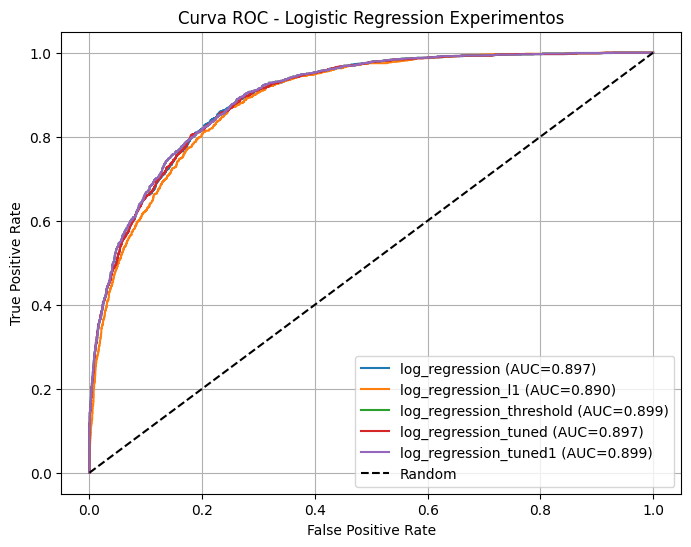

,Accuracy,Precision,Recall,F1,AUC
Modelo,,,,,
log_regression,0.846036,0.734660,0.565051,0.638789,0.896725
log_regression_l1,0.840504,0.719735,0.553571,0.625811,0.889848
log_regression_threshold,0.849570,0.739626,0.579719,0.649982,0.898890
log_regression_tuned,0.846036,0.735441,0.563776,0.638267,0.896609
log_regression_tuned1,0.849570,0.739626,0.579719,0.649982,0.898890


In [26]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)

# Ruta de tus modelos
base_dir = "results_out"
folders = [
    "log_regression",
    "log_regression_l1",
    "log_regression_threshold",
    "log_regression_tuned",
    "log_regression_tuned1"
]

metrics = []

plt.figure(figsize=(8, 6))
for folder in folders:
    # Cargar modelo
    model_path = os.path.join(base_dir, folder, "best_model.joblib")
    model = joblib.load(model_path)
    
    # Predecir probabilidades
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)
    
    # Calcular métricas
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{folder} (AUC={auc:.3f})")
    
    # Guardar para tabla comparativa
    metrics.append({
        "Modelo": folder,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    })

# Graficar ROC curve
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression Experimentos")
plt.legend()
plt.grid(True)
plt.show()

# Tabla comparativa de métricas
metrics_df = pd.DataFrame(metrics).set_index("Modelo")
display(metrics_df.style.background_gradient(cmap="Blues"))


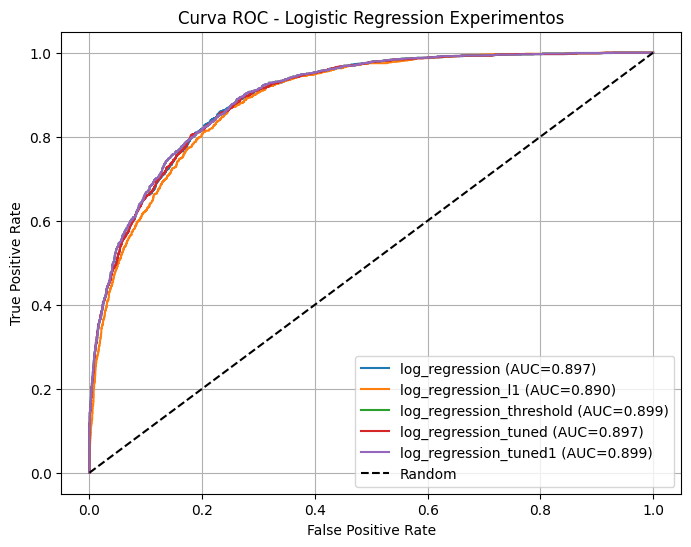

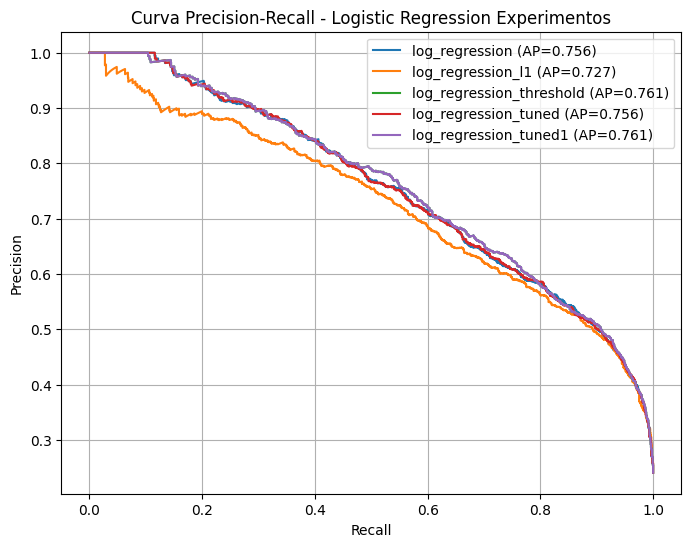

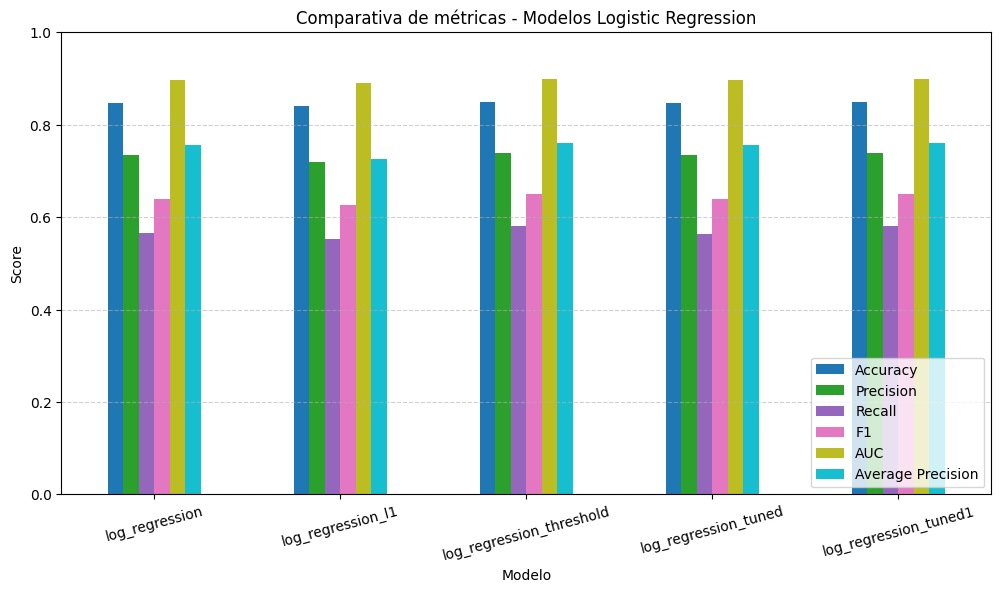

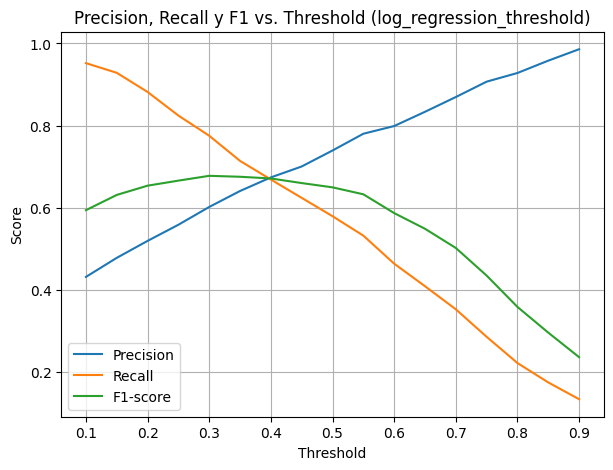

In [30]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score, average_precision_score
)

# Folders de tus modelos
base_dir = "results_out"
folders = [
    "log_regression",
    "log_regression_l1",
    "log_regression_threshold",
    "log_regression_tuned",
    "log_regression_tuned1"
]

# Asumiendo que tienes X_test, y_test listos y sin procesar
metrics = []
roc_curves = {}
pr_curves = {}

plt.figure(figsize=(8, 6))
for folder in folders:
    model_path = os.path.join(base_dir, folder, "best_model.joblib")
    model = joblib.load(model_path)
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # ROC y AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{folder} (AUC={auc:.3f})")
    roc_curves[folder] = (fpr, tpr)
    
    # Precision-Recall curve y Average Precision
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    pr_curves[folder] = (precision, recall, avg_prec)

    # Métricas clásicas (umbral 0.5)
    metrics.append({
        "Modelo": folder,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": auc,
        "Average Precision": avg_prec
    })

# --- 1. ROC CURVES ---
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Logistic Regression Experimentos")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. PRECISION-RECALL CURVES ---
plt.figure(figsize=(8, 6))
for folder, (precision, recall, avg_prec) in pr_curves.items():
    plt.plot(recall, precision, label=f"{folder} (AP={avg_prec:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - Logistic Regression Experimentos")
plt.legend()
plt.grid(True)
plt.show()

# --- 3. BARPLOT DE MÉTRICAS ---
metrics_df = pd.DataFrame(metrics).set_index("Modelo")
metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1", "AUC", "Average Precision"]

metrics_df[metrics_to_plot].plot(
    kind='bar', figsize=(12, 6), colormap="tab10"
)
plt.title("Comparativa de métricas - Modelos Logistic Regression")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.show()

# --- 4. (OPCIONAL) TRADEOFF PRECISION vs RECALL para log_regression_threshold ---
# Solo si has guardado resultados de diferentes thresholds
if "log_regression_threshold" in folders:
    model = joblib.load(os.path.join(base_dir, "log_regression_threshold", "best_model.joblib"))
    y_proba = model.predict_proba(x_test)[:, 1]
    thresholds = np.arange(0.1, 0.91, 0.05)
    precision_list, recall_list, f1_list = [], [], []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        precision_list.append(precision_score(y_test, y_pred))
        recall_list.append(recall_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred))
    plt.figure(figsize=(7,5))
    plt.plot(thresholds, precision_list, label="Precision")
    plt.plot(thresholds, recall_list, label="Recall")
    plt.plot(thresholds, f1_list, label="F1-score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall y F1 vs. Threshold (log_regression_threshold)")
    plt.legend()
    plt.grid(True)
    plt.show()


## Conclusiones Finales

Se exploraron en total nueve bloques de experimentos, cinco con Random Forest y cuatro con Regresión Logística, evaluando combinaciones de imputación, tratamiento de outliers, agrupamiento de categorías (min_freq), regularización y threshold de decisión.

🟩 Random Forest

Logró los mejores scores generales de accuracy y f1.

El uso de class_weight y el agrupamiento de categorías mostró mejoras en recall en la clase minoritaria.

Agrupar categorías poco frecuentes en native.country, occupation y workclass fue clave, mejoró la estabilidad sin pérdida fuerte de precisión.

El clip de outliers tuvo poco impacto por sí solo, pero fue útil cuando se combinó con otras técnicas.

🟦 Regresión Logística

Penalización L2 con C entre 0.05 y 0.1 dio mejores resultados.

Penalización L1 simplificó el modelo pero redujo el recall.

El preprocesamiento óptimo incluyó imputación por mediana, clip moderado de outliers y MinMaxScaler.

Ajustar el threshold de decisión: Un threshold ≈ 0.4 maximiza el F1, y permite balancear recall y precision según el target.

🧭 Síntesis

Random Forest tuvo mejor rendimiento sin necesidad de tuning fino.

Logistic Regression permite un control más explícito sobre decisiones, con buena performance y mas interpretable.